<div style="line-height:0.5">
<h1 style="color:#FF7C00  "> Convolutional Neural Networks in TensorFlow 3 </h1>
<h4>   </h4>

<div style="line-height:1.4; margin-top: 1em;">
    <h3 style="color: lightblue; display: inline; margin-right: 0.5em;">Keywords:</h3>  
    jedi completion in Colab + runtime device type + CV2 OpenCV for image manipulation + imghdr + Colab files + save models + TensorBoard callbacks
</div> 

In [1]:
%%script echo Skipping if not on Colab
# autocompletion
# !pip install jedi
%config Completer.use_jedi = True

Skipping if not on Colab


In [2]:
%%script echo Skipping since already installed
!pip install --upgrade numpy

Skipping since already installed


In [3]:
%%script echo Skipping since already installed
!pip list

Skipping since already installed


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import torch

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

import cv2             
import imghdr          

In [4]:
%%script echo Uncomment if Colab in use
from google.colab import files

Uncomment if Colab in use


In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
""" Avoid OOM errors by setting GPU Memory Consumption Growth. """
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Check runtime type with tf
tf.config.list_physical_devices('GPU')

[]

In [ ]:
# Check runtime type with pytorch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


<h2 style="color:#FF7C00  "> <u> Example #1 </u> </h2>

<h3 style="color:#FF7C00  "> Note: </h3>
<div style="margin-top: -8px;">
On Colab it is not possible to upload files directly from the filesystem, it is needed to upload them /content, or create a link with gdrive.
</div>

In [ ]:
""" Prompt the user to select a file from their local machine.
N.B. => To upload a folder it must be compressed !
"""
uploaded = files.upload()

Saving data.zip to data.zip


In [ ]:
# %%script echo Skipping, uncomment if Colab not in use

## Get the archive name and contents
archivename = next(iter(uploaded))
content = uploaded[archivename]

## Write the contents to a corresponding folder in Colab's temporary storage
with zipfile.ZipFile(archivename, 'r') as zip_ref:
    zip_ref.extractall('/content')

print(f"The contents of the folder '{os.path.splitext(archivename)[0]}'\
        have been uploaded to '/content/{os.path.splitext(archivename)[0]}/' in Colab's temporary storage.")

The contents of the folder 'data' have been uploaded to '/content/data/' in Colab's temporary storage.


In [ ]:
%%script echo Skipping, just for Colab
# Look inside /content folder
dir_path = '/content'
dir_contents = os.listdir(dir_path)
print(dir_contents)

skippingn


In [ ]:
data_dir = '/content/data'
# Define the list of imag extensions to keep
image_exts = ['jpeg', 'jpg', 'bmp', 'png']  

In [ ]:
""" Read images using OpenCV and iterating through the directories in 'data_dir'.
Skip files with extension that is not in the specified list. 
"""
for image_class in os.listdir(data_dir):
    # Construct the full path to the current image class directory
    class_dir = os.path.join(data_dir, image_class)
    # Check if 'class_dir' is a directory; if not, skip to the next 
    if not os.path.isdir(class_dir):
        continue
    for image in os.listdir(class_dir):
        # Construct the full path to the image file
        image_path = os.path.join(class_dir, image)   
        # Check if 'image_path' is a file; if not, skip to the next 
        if not os.path.isfile(image_path):
            continue
        try:
            # Read the image using OpenCV
            img = cv2.imread(image_path)   
            # Determinate the extension type
            tip = imghdr.what(image_path)  
            # Check if the image extension is not in the 'image_exts' list
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            #os.remove(image_path)          # Uncomment to remove also the problematic image

In [ ]:
!ls /content/happy

ls: cannot access '/content/happy': No such file or directory


In [ ]:
data_dir = '/content/data'
dir_contents = os.listdir(data_dir)
print(dir_contents)

['happy_images.zip', 'happy', 'sad']


In [ ]:
batch_size = 32
img_height, img_width = 256, 256

########## Create an ImageDataGenerator object for for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

######### Create the training dataset
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # 'binary' if there are only 2 classes
    subset='training',
    shuffle=True,
    seed=123)

######### Create the validation dataset
val_data = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # 'binary' if there are only 2 classes
    subset='validation',
    shuffle=True,
    seed=123)

Found 245 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [ ]:
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    labels='inferred',
    label_mode='binary',   
    validation_split=0.2,
    subset='training',
    seed=123,
    class_names=None)

print(type(data))

Found 305 files belonging to 2 classes.
Using 244 files for training.
<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [ ]:
data_iterator = data.as_numpy_iterator()
data_iterator

In [ ]:
batch = data_iterator.next()
batch

(array([[[[ 38.       ,  40.       ,  37.       ],
          [ 38.       ,  40.       ,  37.       ],
          [ 38.       ,  40.       ,  37.       ],
          ...,
          [ 56.09375  ,  62.09375  ,  58.09375  ],
          [ 57.65625  ,  63.65625  ,  59.65625  ],
          [ 58.       ,  64.       ,  60.       ]],
 
         [[ 38.       ,  40.       ,  37.       ],
          [ 38.       ,  40.       ,  37.       ],
          [ 38.       ,  40.       ,  37.       ],
          ...,
          [ 56.372375 ,  62.372375 ,  58.372375 ],
          [ 57.565613 ,  63.565613 ,  59.565613 ],
          [ 57.828125 ,  63.828125 ,  59.828125 ]],
 
         [[ 38.       ,  40.       ,  37.       ],
          [ 38.       ,  40.       ,  37.       ],
          [ 38.       ,  40.       ,  37.       ],
          ...,
          [ 57.638855 ,  63.638855 ,  59.638855 ],
          [ 57.153625 ,  63.153625 ,  59.153625 ],
          [ 57.046875 ,  63.046875 ,  59.046875 ]],
 
         ...,
 
         [[ 

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


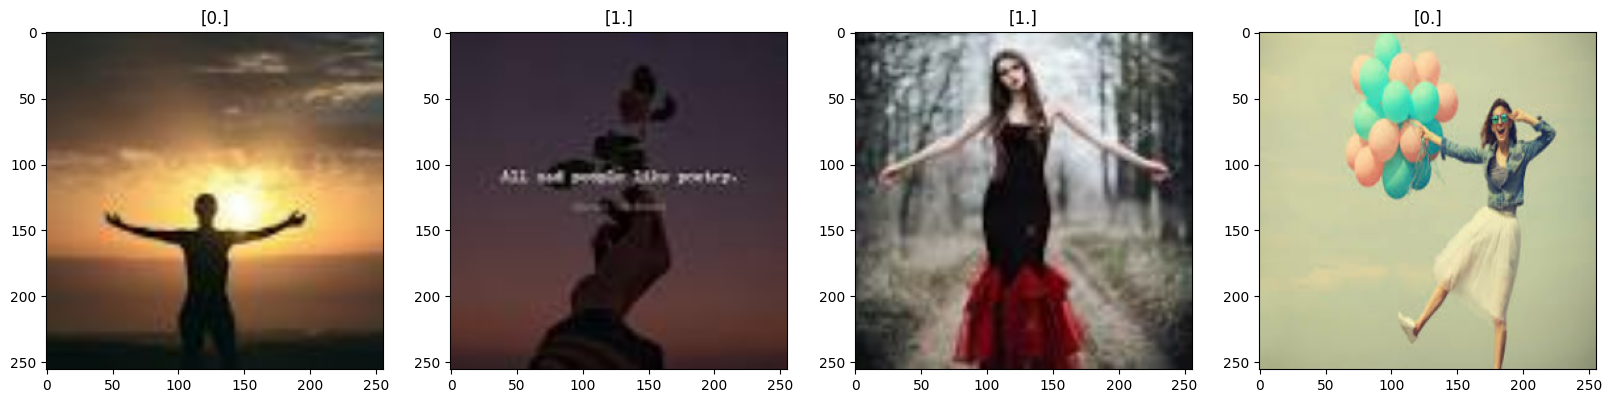

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

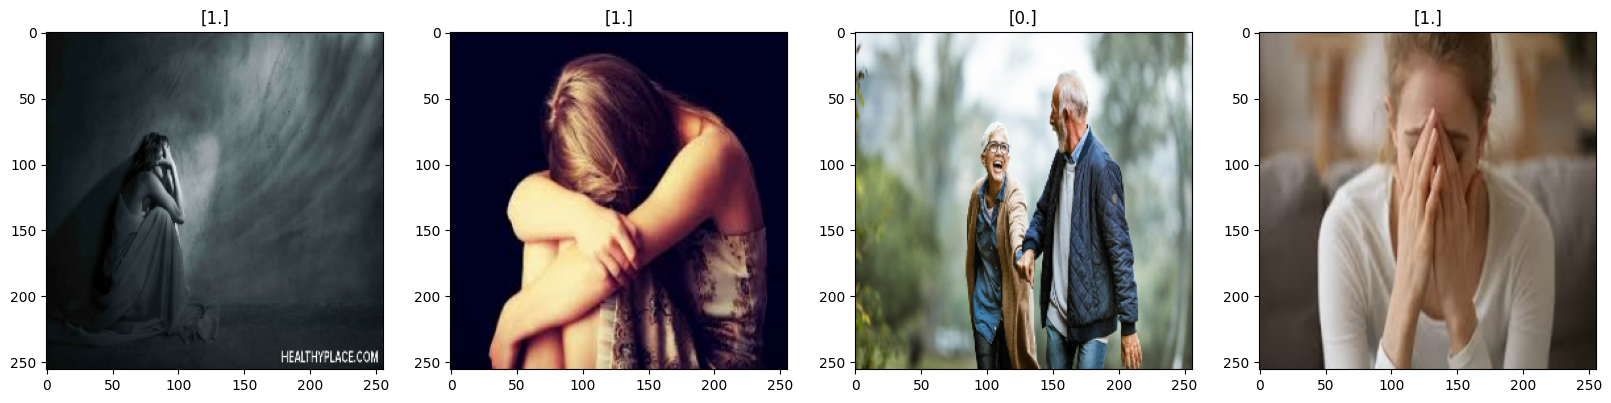

In [ ]:
""" Scaling.
N.B.
#** To use imshow 'img' need to be multiplied to 255 to avoid to get black images,
since the img.astype(int) cast to 0 the floating point number when trying to convert to an integer...
"""
# Dividing x by 255 means scaling image to a range from 0 to 1
data_scaled = data.map(lambda x,y: (x/255, y)) 
batch_ds = data_scaled.as_numpy_iterator().next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch_ds[0][:4]):
    ax[idx].imshow((img*255).astype(int))           #**
    ax[idx].title.set_text(batch_ds[1][idx])

In [ ]:
""" Split data. Train set gets the 70% of the original dataset. """

train_size = int(len(data_scaled)*.7) 
val_size = int(len(data_scaled)*.2)
test_size = int(len(data_scaled)*.1)

train = data_scaled.take(train_size)
val = data_scaled.skip(train_size).take(val_size)
test = data_scaled.skip(train_size+val_size).take(test_size)

print("sizes: ")
print(train_size)
print(val_size)
print(test_size)
print()
print(f"type train is => {type(train)}")

sizes: 
5
1
0

type train is => <class 'tensorflow.python.data.ops.take_op._TakeDataset'>


In [ ]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [ ]:
type(train)

tensorflow.python.data.ops.take_op._TakeDataset

In [ ]:
data_iterator_train = train.take(1).as_numpy_iterator()
for bat in data_iterator_train:
    print(bat)

(array([[[[0.00784314, 0.00784314, 0.00784314],
         [0.00818015, 0.00818015, 0.00818015],
         [0.00971201, 0.00971201, 0.00971201],
         ...,
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412]],

        [[0.00750613, 0.00750613, 0.00750613],
         [0.0078721 , 0.0078721 , 0.0078721 ],
         [0.00953561, 0.00953561, 0.00953561],
         ...,
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412]],

        [[0.00597426, 0.00597426, 0.00597426],
         [0.00647188, 0.00647188, 0.00647188],
         [0.00873377, 0.00873377, 0.00873377],
         ...,
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412],
         [0.03529412, 0.03529412, 0.03529412]],

        ...,

        [[0.08440564, 0.08440564, 0.08440564],
         [0.08527186, 0.08527186, 0.08527186

In [ ]:
""" Show new_data Tensor
N.B.1
The first tensor has shape (32, 224, 224, 3) and represents a batch of 32 images, 
each of size 224x224 pixels with 3 color channels (RGB).
N.B.2
The second tensor has shape (32, 1) and represents the corresponding labels for the batch of images, 
where each label is a binary value of 0 or 1. 
"""
new_data = train.take(1)
for element in new_data:
    print(element)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[9.68627453e-01, 9.68627453e-01, 9.29411769e-01],
         [9.68627453e-01, 9.68627453e-01, 9.29411769e-01],
         [9.68627453e-01, 9.68627453e-01, 9.29411769e-01],
         ...,
         [9.77198243e-01, 9.79381144e-01, 9.39437807e-01],
         [9.76470590e-01, 9.76470590e-01, 9.37254906e-01],
         [9.76470590e-01, 9.76470590e-01, 9.37254906e-01]],

        [[9.68627453e-01, 9.68627453e-01, 9.29411769e-01],
         [9.68627453e-01, 9.68627453e-01, 9.29411769e-01],
         [9.68627453e-01, 9.68627453e-01, 9.29411769e-01],
         ...,
         [9.77198243e-01, 9.79381144e-01, 9.39437807e-01],
         [9.76470590e-01, 9.76470590e-01, 9.37254906e-01],
         [9.76470590e-01, 9.76470590e-01, 9.37254906e-01]],

        [[9.68627453e-01, 9.68627453e-01, 9.29411769e-01],
         [9.68627453e-01, 9.68627453e-01, 9.29411769e-01],
         [9.68627453e-01, 9.68627453e-01, 9.29411769e-01],
         ...,
         

In [1]:
input_shape = (256, 256, 3)
def resize_fn(x,y):
    """ Resize each batch of data. """
    x_resized = tf.image.resize(x, input_shape[:2])
    return x_resized, y

"""
# Resize input data using the map method
train_resized = train.map(resize_fn)
val_resized = val.map(resize_fn)
""";

<h2 style="color:#FF7C00  "> <u> Example #2: simple FFN (Feedforward Network) </u> </h2>

In [ ]:
model = Sequential() 

In [ ]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))

In [ ]:
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu')) # 32 filters, 3x3 kernel size and RELU activation func
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))            # Fully connected layer with 64 units and ReLU activation
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model with categorical cross-entropy loss without specifying the optimizer (e.g. stochastic gradient descent)
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [ ]:
logdir='logs'
logdir

'logs'

<h3 style="color:#FF7C00  ">  Recap: </h3>
<div style="margin-top: -8px;">
TensorBoard tool permits to visualize and monitor the training and evaluation of the deep learning model. <br>
It provides a web interface that displays various useful information about model's performance, <br>
such as metrics, loss, and accuracy, as well as visualizations of the model's graph, histograms of weights and biases. <br>

The TensorBoard callback is used to log data to a specified directory during training and evaluation. <br>
It can be launched by pointing it to the log directory, to display the logged data on the web interface. <br>
</div>

In [ ]:
# Write the log
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # 'log_dir' specifies the directory

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
5/5 [==============================] - 19s 3s/step - loss: 1.1110 - accuracy: 0.5312 - val_loss: 0.7995 - val_accuracy: 0.5625
Epoch 2/20
5/5 [==============================] - 18s 3s/step - loss: 0.7855 - accuracy: 0.4500 - val_loss: 0.6582 - val_accuracy: 0.5312
Epoch 3/20
5/5 [==============================] - 17s 3s/step - loss: 0.6360 - accuracy: 0.5625 - val_loss: 0.5475 - val_accuracy: 0.7812
Epoch 4/20
5/5 [==============================] - 17s 3s/step - loss: 0.5848 - accuracy: 0.7250 - val_loss: 0.7785 - val_accuracy: 0.7188
Epoch 5/20
5/5 [==============================] - 17s 3s/step - loss: 0.5259 - accuracy: 0.7375 - val_loss: 0.3689 - val_accuracy: 0.8438
Epoch 6/20
5/5 [==============================] - 17s 3s/step - loss: 0.4576 - accuracy: 0.7750 - val_loss: 0.3968 - val_accuracy: 0.8125
Epoch 7/20
5/5 [==============================] - 17s 3s/step - loss: 0.3725 - accuracy: 0.8250 - val_loss: 0.1987 - val_accuracy: 0.9688
Epoch 8/20
5/5 [==================

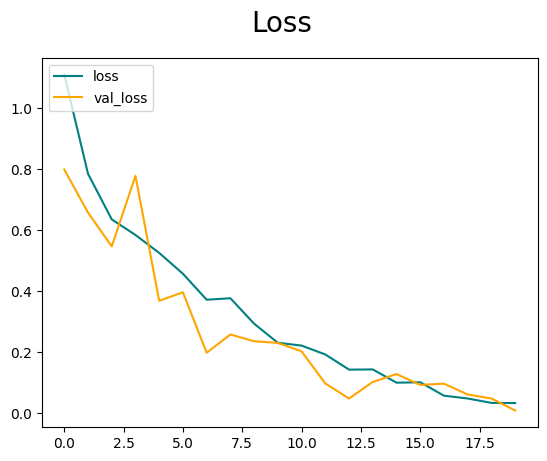

In [ ]:
""" Show Loss graph """
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

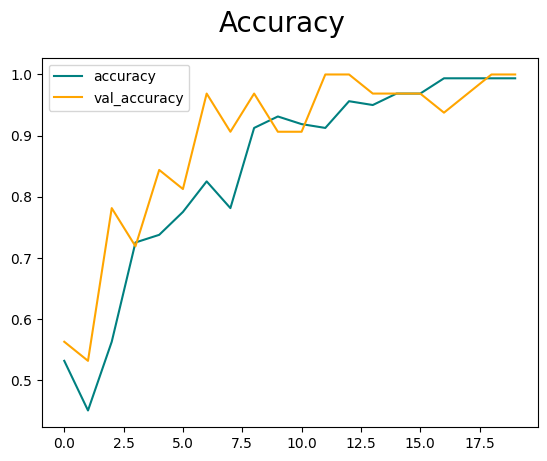

In [ ]:
""" Show Accuracy graph """
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


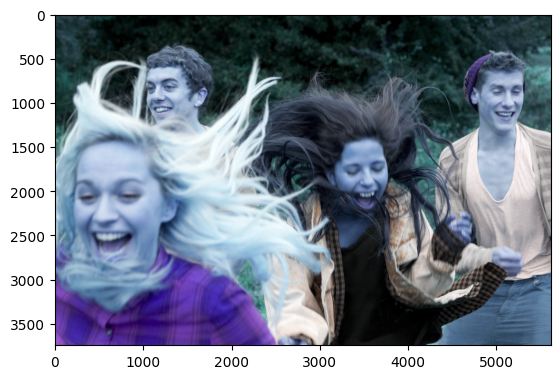

In [ ]:
# Load the image
img = cv2.imread('/content/data/happy/154006829.jpg')

### Check that the image was loaded correctly
if img is None:
    print('Failed to load image')
    exit()

# Convert the data type to a floating point data type
img = img.astype(np.float32) / 255.0

## Display the image
plt.imshow(img)
plt.show()

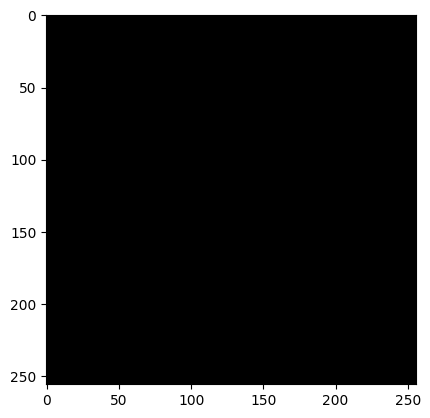

In [ ]:
""" Resize """
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat = model.predict(np.expand_dims(resize/255, 0))
yhat


1/1 [==============================] - 0s 153ms/step


array([[1.]], dtype=float32)

In [ ]:
""" Save the model """
model.save(os.path.join('models','imageclassifier.h5'))
new_model = load_model('/content/models/imageclassifier.h5')
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 95ms/step


array([[1.]], dtype=float32)